# Tutorial about using PYLEECAN's loss model

### Version information

In [1]:
import sys
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\LAP10\Documents\Loss\pyleecan")
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print(f'Pyleecan version : {pyleecan.__version__}')
import SciDataTool
print(f'SciDataTool version : {SciDataTool.__version__}')

Running date: June 02, 2022
Pyleecan version : 1.3.8
SciDataTool version : 2.3.10


### Importing of the machine

The machines used in this tutorial will be the Toyota Prius machine.

In [2]:
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

machine = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

## First loss Simulation

A first loss simulation on one operating point will be carried out in this section.

### Definition of the simulation

A simulation is defined using the Pyleecan objects.

In [3]:

%matplotlib inline
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.LossFEMM import LossFEMM
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.LossModelBertotti import LossModelBertotti
from pyleecan.Classes.LossModelWinding import LossModelWinding
from pyleecan.Classes.LossModelProximity import LossModelProximity
from pyleecan.Classes.LossModelMagnet import LossModelMagnet
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

from SciDataTool.Functions.Plot.plot_2D import plot_2D 

plt.rcParams['figure.dpi'] = 120

simu = Simu1(name="test_FEMM_Loss_Prius", machine=machine)

Cprox=0

Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=False,
)

# A loss model is created. is_show_fig is set to True to see the curve-fitting figure, otherwise to False
simu.loss = LossFEMM(
    is_get_meshsolution=True,
    Tsta=100,
    model_dict={"stator core": LossModelSteinmetz(group = "stator core"),
                "rotor core": LossModelSteinmetz(group = "rotor core"),
                "joule": LossModelWinding(group = "stator winding"),
                "proximity": LossModelProximity(group = "stator winding"),
                "magnets": LossModelMagnet(group = "rotor magnets")}
)

Once set up, the simulation can simply be run using the *run* method.

In [4]:
out = simu.run()

[10:57:13] Starting running simulation test_FEMM_Loss_Prius (machine=Toyota_Prius)
[10:57:13] Starting Magnetic module
[10:57:16] Solving time steps: 0%
[10:57:17] Solving time steps: 0%
[10:57:17] Solving time steps: 0%
[10:57:18] Solving time steps: 0%
[10:57:24] Solving time steps: 25%
[10:57:24] Solving time steps: 25%
[10:57:26] Solving time steps: 25%
[10:57:27] Solving time steps: 25%
[10:57:38] Solving time steps: 50%
[10:57:39] Solving time steps: 50%
[10:57:41] Solving time steps: 50%
[10:57:42] Solving time steps: 50%
[10:57:50] Solving time steps: 75%
[10:57:50] Solving time steps: 75%
[10:57:52] Solving time steps: 75%
[10:57:52] Solving time steps: 75%
[10:57:55] Solving time step: 100%
[10:57:55] Solving time step: 100%
[10:57:56] Solving time step: 100%
[10:57:56] Solving time step: 100%
[10:57:56] Running LossFEMM module
[10:57:58] End of simulation test_FEMM_Loss_Prius


Now, the results are stored in the Output object named out. The loss powers can be printed.

In [5]:
power_dict = {
    "total_power": out.mag.Pem_av,
    **dict([(o.name,o.get_loss_scalar(out.elec.OP.felec)) for o in out.loss.loss_list])
}
print(power_dict)

{'total_power': 54596.16454513997, 'stator core': 292.64231427566983, 'rotor core': 14.808162839541831, 'joule': 9280.711941951115, 'proximity': 16.826278435456278, 'magnets': 12.171698693315596, 'overall': 9617.160396195097}


### Plotting the distribution of the losses in the machine

The meshsolution is stored in the output of the simulation, allowing to plot the machine with the loss values in each elements. The loss values can be separated by each type of loss.

In [6]:
group_names = [
    "stator core",
    "rotor core",
    "rotor magnets"
]
for loss in out.loss.loss_list:
    if "joule" in loss.name or "proximity" in loss.name :
        group_names.append("stator winding")
        loss.get_mesh_solution().plot_contour(
            "freqs=sum",
            label=f"{loss.name} Loss",
            group_names = group_names
        )
        group_names.pop()
    else:
        
        loss.get_mesh_solution().plot_contour(
            "freqs=sum",
            label=f"{loss.name} Loss",
            group_names = group_names
        )

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## Plotting loss with respect to the rotation speed

The lossFEMM object stores coefficients computed from the first simu. These coefficients allow to plot the losses with respect to the rotation speed of the machine without carrying other simulations.

c:\Users\LAP10\AppData\Local\Programs\Python\Python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:482: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


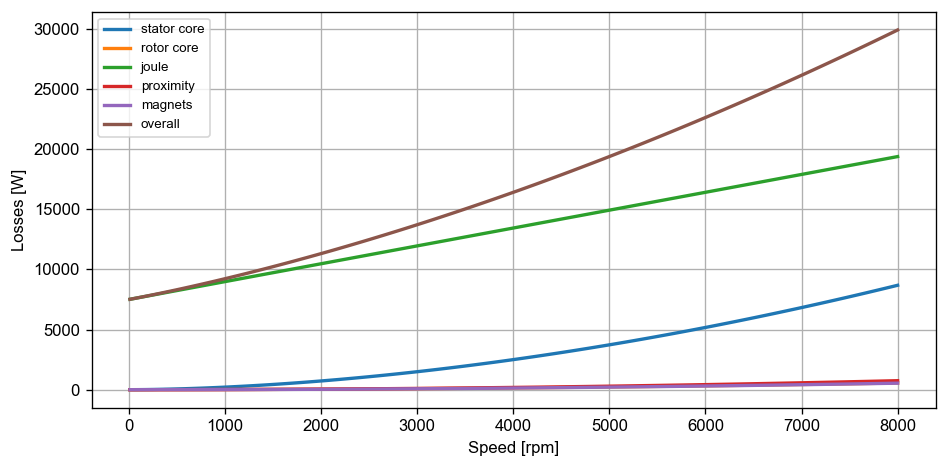

In [7]:
speed_array = np.linspace(10, 8000, 100)
p = machine.get_pole_pair_number()

array_list = [np.array([o.get_loss_scalar(speed / 60 *p) for speed in speed_array])
                for o in out.loss.loss_list if o.name != 'overall']
array_list.append(sum(array_list))

plot_2D(
    [speed_array],
    array_list,
    xlabel="Speed [rpm]",
    ylabel="Losses [W]",
    legend_list=[o.name for o in out.loss.loss_list] + ["overall loss"],
)

## Efficiency map of the machine

The efficiency map of the machine can be constructed by going through several steps.

### Defining a Look up table (LUT)

A look up table is first needed to allow faster computation  during all the simulations. This LUT stores several quantities with respect to the currents $I_d$ and $I_q$.

The LUT can be stored so it is not calculated each time the scipt is run. If this is the first time and the LUT does not exists, it is set to None and will be computed before running other simulations.

In [12]:
from os.path import exists, split

path_to_LUT = r"C:\Users\LAP10\Documents\Loss\LUT_nb.h5"

if not exists(split(path_to_LUT)[0]):
    raise Exception("The path to LUT is not valid.")
try:
    LUT_enforced = load(path_to_LUT)
    is_LUT_exists = True
except FileNotFoundError:
    print("The LUT could not be loaded, so it will be computed.")
    LUT_enforced = None
    is_LUT_exists = False

The LUT could not be loaded, so it will be computed.


The next step is to define Simulation containing a *var_simu* attribute with a *VarLoadCurrent*. The *VarLoadCurrent* object needs an *OP_matrix* to define several operating points to carry out multiple simulations. The *OP_matrix* is a matrix with 3 columns representing the following quantities :
1. Rotation speed
2. $I_d$
3. $I_q$

In [13]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent

simu = Simu1(name="test_ElecLUTdq_efficiency_map", machine=machine)

Nspeed = 50

OP_matrix = np.zeros((Nspeed, 3))
OP_matrix[:, 0] = np.linspace(500, 8000, Nspeed)
simu.var_simu = VarLoadCurrent(
    OP_matrix=OP_matrix, type_OP_matrix=1, is_keep_all_output=True
)

simu.input = InputCurrent(
    OP=OPdq(),
    Nt_tot=4 * 8,
    Na_tot=200 * 8,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu.input.set_OP_from_array(OP_matrix, type_OP_matrix=1)

The electrical module of the simulation needs to be an ElecLUTdq object to take into account the LUT previously defined.

In [14]:
from pyleecan.Classes.ElecLUTdq import ElecLUTdq
from pyleecan.Classes.PostLUT import PostLUT

# Definition of a loss model
loss_model = LossModelSteinmetz()

simu.elec = ElecLUTdq(
    Urms_max=400,
    Jrms_max=30e6,
    n_interp=100,
    n_Id=5,
    n_Iq=5,
    Id_max=0,
    Iq_min=0,
    LUT_enforced=LUT_enforced,
    is_grid_dq=True,
    LUT_simu=Simu1(
        input=InputCurrent(
            OP=OPdq(),
            Nt_tot=4 * 8,
            Na_tot=200 * 8,
            is_periodicity_a=True,
            is_periodicity_t=True,
        ),
        var_simu=VarLoadCurrent(
            type_OP_matrix=1,
            postproc_list=[PostLUT(is_save_LUT=False)],
            is_keep_all_output=True,
        ),
        mag=MagFEMM(
            is_periodicity_a=True,
            is_periodicity_t=True,
            nb_worker=4,
            is_get_meshsolution=True,
        ),
            loss = LossFEMM(
                is_get_meshsolution=True,
                Tsta=100,
                model_dict={"stator core": LossModelSteinmetz(group = "stator core"),
                            "rotor core": LossModelSteinmetz(group = "rotor core"),
                            "joule": LossModelWinding(group = "stator winding"),
                            "proximity": LossModelProximity(group = "stator winding"),
                            "magnets": LossModelMagnet(group = "rotor magnets")}
            )
    ),
)

Now comes the core of the algorithms. For several values of load rates (defining the required torque), a simlation will be run for every values of speed in the *OP_matrix*. The simulations will be very fast as the magnetic and loss quantities are interpolated from the LUT previously computed.

In [15]:
# Nload simulations will be carried out with load values between 0.1 and 1
Nload = 5
load_vect = np.linspace(0.1, 1, Nload)

# Several matrixes that will contain relevant data for post_processing are created
OP_matrix_MTPA = np.zeros((Nspeed, Nload, 5))
U_MTPA = np.zeros((Nspeed, Nload, 3))
I_MTPA = np.zeros((Nspeed, Nload, 3))
Phidq_MTPA = np.zeros((Nspeed, Nload, 2))

# An output list is created to contain the Nload outputs that will be computed
out_load = list()

for ii, load_rate in enumerate(load_vect):
    # Re using the LUT computed during the first step
    if ii > 0 and LUT_enforced is None:
        simu.elec.LUT_enforced = out.output_list[0].simu.elec.LUT_enforced

    simu.elec.load_rate = load_rate

    out = simu.run()

    # Store values in MTPA, the five columns of the OP_matrix_MTPA will be filled
    # First column is rotational speed
    OP_matrix_MTPA[:, ii, 0] = out["N0"].result
    # Second columns is Id
    OP_matrix_MTPA[:, ii, 1] = out["Id"].result
    # Third column is Iq
    OP_matrix_MTPA[:, ii, 2] = out["Iq"].result
    # Fourth column is the average torque
    OP_matrix_MTPA[:, ii, 3] = [out_ii.elec.Tem_av for out_ii in out.output_list]
    # Fifth column is the efficiency
    OP_matrix_MTPA[:, ii, 4] = [out_ii.elec.OP.efficiency for out_ii in out.output_list]
    
    # Store the voltages and currents in two dedicated matrixes
    # First column is Ud
    U_MTPA[:, ii, 0] = [out_ii.elec.OP.Ud_ref for out_ii in out.output_list]
    # Second column is Uq
    U_MTPA[:, ii, 1] = [out_ii.elec.OP.Uq_ref for out_ii in out.output_list]
    # Third column is U0
    U_MTPA[:, ii, 2] = [
        out_ii.elec.OP.get_U0_UPhi0()["U0"] for out_ii in out.output_list
    ]
    # First column is Id
    I_MTPA[:, ii, 0] = OP_matrix_MTPA[:, ii, 1]
    # Second column is Iq
    I_MTPA[:, ii, 1] = OP_matrix_MTPA[:, ii, 2]
    # Third column is I0
    I_MTPA[:, ii, 2] = [
        out_ii.elec.OP.get_I0_Phi0()["I0"] for out_ii in out.output_list
    ]
    # The fluxes are also stored in their dedicated matrix
    # First column is phid
    Phidq_MTPA[:, ii, 0] = [out_ii.elec.eec.Phid for out_ii in out.output_list]
    # second column is phiq
    Phidq_MTPA[:, ii, 1] = [out_ii.elec.eec.Phiq for out_ii in out.output_list]
    # The output of the current simulation is appended to the list of outputs
    out_load.append(out)

[11:00:36] Starting running simulation test_ElecLUTdq_efficiency_map (machine=Toyota_Prius)
[11:00:36] Computing reference simulation for Variable Load
[11:00:36] Starting Electrical module
[11:00:36] Starting running simulation (machine=Toyota_Prius)
[11:00:36] Computing reference simulation for Variable Load
[11:00:36] Starting Magnetic module
[11:00:38] Computing Airgap Flux in FEMM
[11:00:43] Running LossFEMM module
[11:00:44] Variable Load Reference Results: N0=500 [rpm], Id=-254.8 [Arms], Iq=0 [Arms], Tem_av=-0.3026 [N.m], Tem_rip_pp=25.87 [N.m], Tem_rip_norm=-85.48 [-], Pem_av=-15.85 [W]
[=                                                 ]   3%
[11:00:44] Variable Load: Using same FEMM file for all simulations (C:\Users\LAP10\Documents\Loss\pyleecan\pyleecan\Results\Femm\Toyota_Prius_model.fem)
[11:00:44] Running simulation 1/25 with N0=500 [rpm], Id=-254.8 [Arms], Iq=0 [Arms]
[11:00:44] Simulation matches reference one: Skipping computation
[11:00:44] Variable Load Results: N0=

At the end, the LUT can be stored if it did not exists and has been computed.

In [16]:
if not is_LUT_exists:
    simu.elec.LUT_enforced.save(save_path=path_to_LUT)

## Plots

We need to import plots functions from SciDataTool.

In [17]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from SciDataTool.Functions.Plot.plot_3D import plot_3D
#Set the resolution of the figure to make them bigger
plt.rcParams['figure.dpi'] = 150

Now we can simply plot the eficiency map using this code.

c:\Users\LAP10\AppData\Local\Programs\Python\Python38\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:371: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


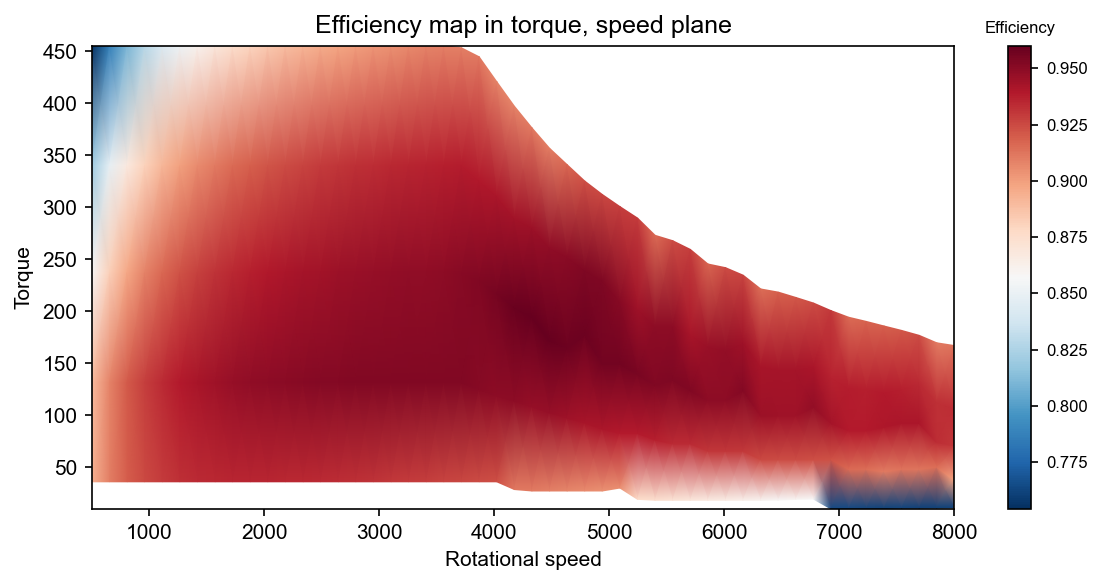

In [18]:
#init plot map for efficiency
dict_eff_map = {
    "Xdata": OP_matrix_MTPA[:, :, 0],  # Rotational speed
    "Ydata": OP_matrix_MTPA[:, :, 3],  # Torque
    "xlabel": "Rotational speed",
    "ylabel": "Torque",
    "type_plot": "pcolormesh",
    "is_contour": True,
}

plot_3D(
    Zdata=OP_matrix_MTPA[:, :, 4],
    zlabel="Efficiency",
    title="Efficiency map in torque, speed plane",
    **dict_eff_map,
)

Also, the losses can be plotted as a function of $I_d$/$I_q$ thanks to the look up table.

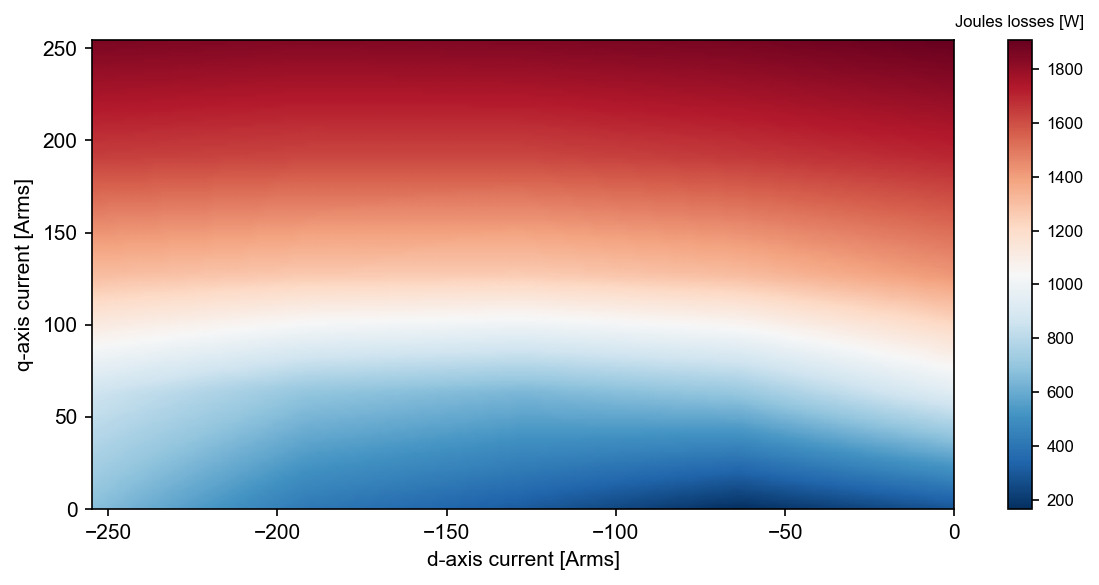

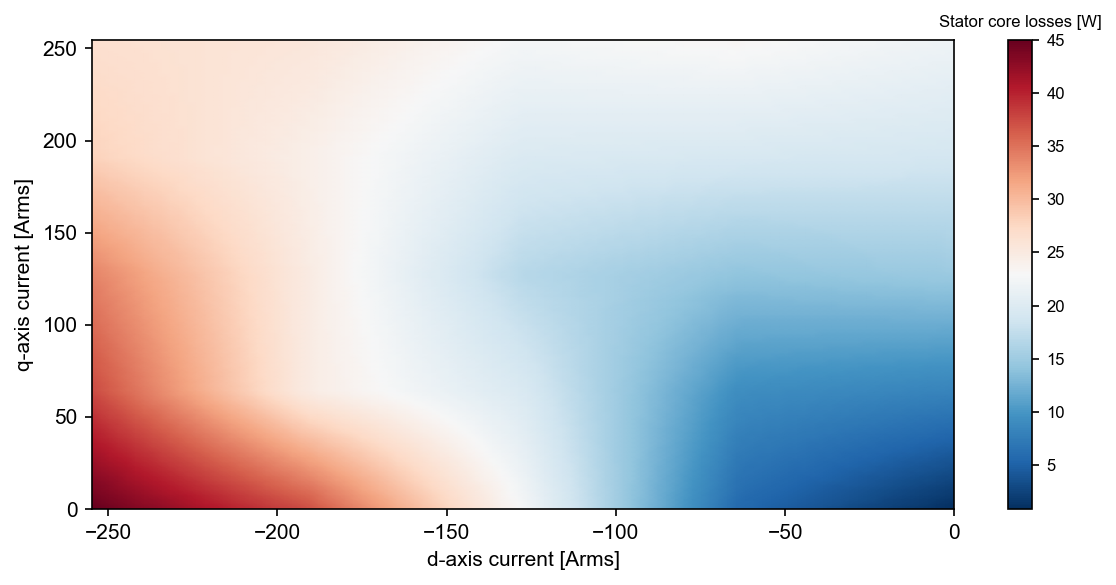

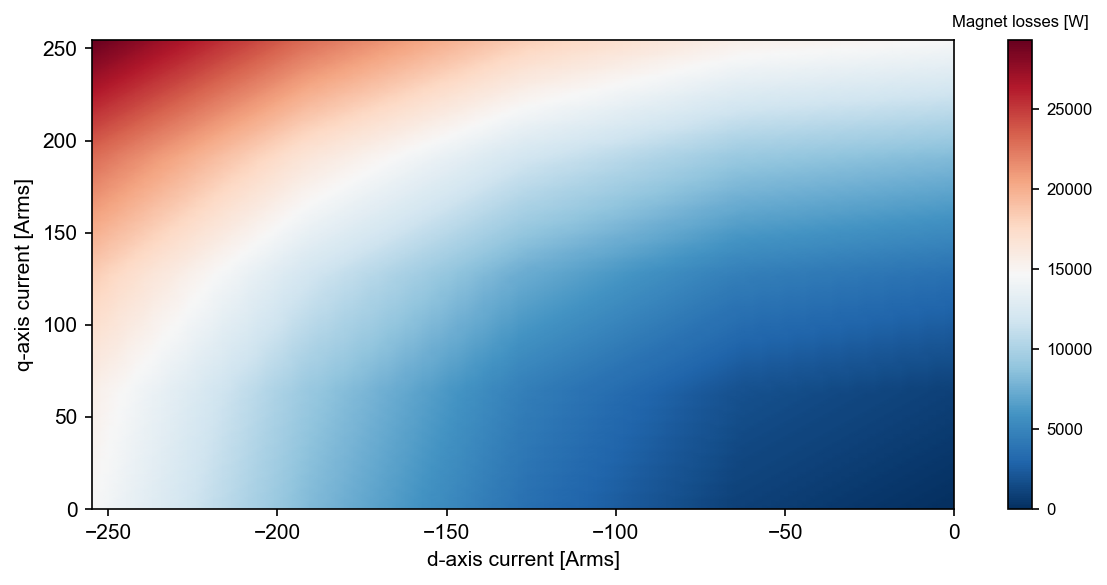

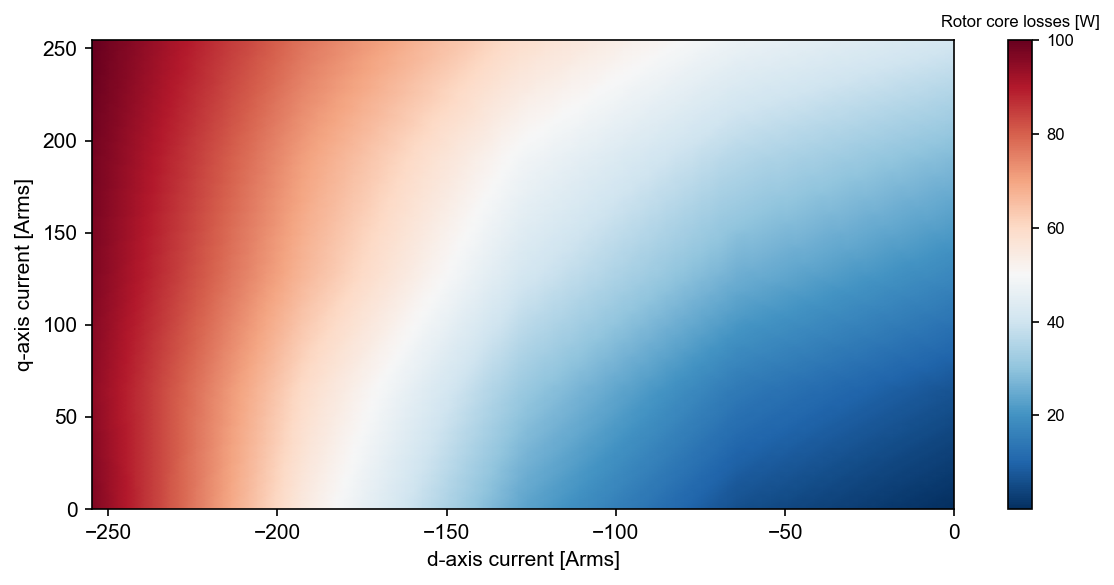

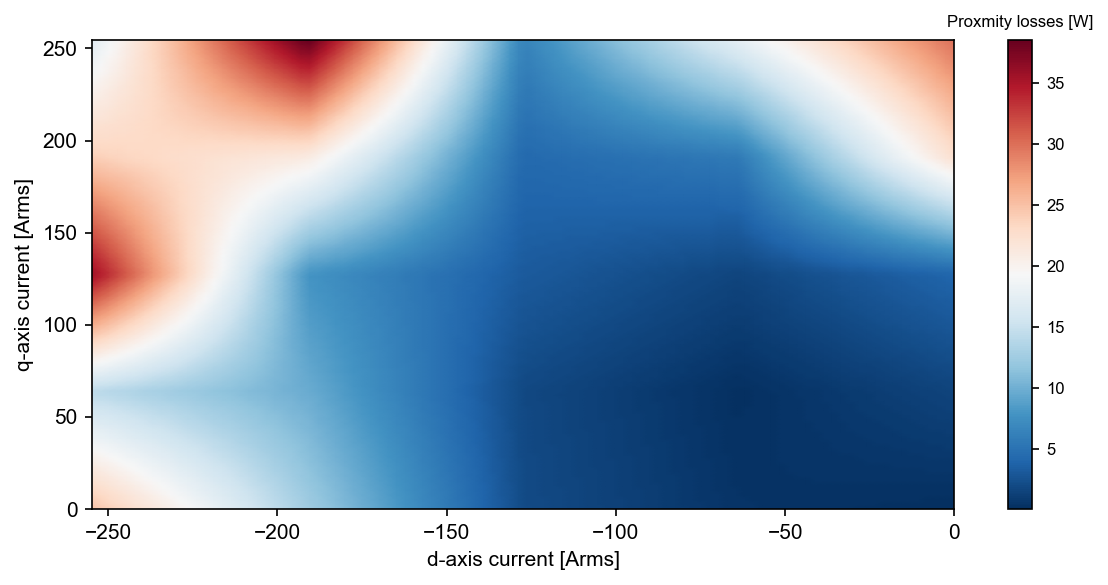

In [19]:
LUT_grid = out.simu.elec.LUT_enforced

# Get Id_min, Id_max, Iq_min, Iq_max from OP_matrix
OP_matrix = LUT_grid.get_OP_matrix()
Id_min = OP_matrix[:, 1].min()
Id_max = OP_matrix[:, 1].max()
Iq_min = OP_matrix[:, 2].min()
Iq_max = OP_matrix[:, 2].max()

nd, nq = 100, 100
Id_vect = np.linspace(Id_min, Id_max, nd)
Iq_vect = np.linspace(Iq_min, Iq_max, nq)
Id, Iq = np.meshgrid(Id_vect, Iq_vect)
Id, Iq = Id.ravel(), Iq.ravel()

# Interpolate Phid/Phiq on the refined mesh

Ploss_dqh = LUT_grid.interp_Ploss_dqh(Id, Iq, N0=3000)
dict_map = {
    "Xdata": Id.reshape((nd, nq))[0, :],
    "Ydata": Iq.reshape((nd, nq))[:, 0],
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolormesh",
    "is_contour": True,
}
loss_list = ["Joules losses",
            "Stator core losses",
            "Magnet losses",
            "Rotor core losses",
            "Proxmity losses"]
for i, loss in enumerate(loss_list):
    plot_3D(
            Zdata=Ploss_dqh[:, i].reshape((nd, nq)),
            zlabel=f"{loss} [W]",
            **dict_map,
        )

Also, the torque can be plotted as a function of $I_d$/$I_q$.

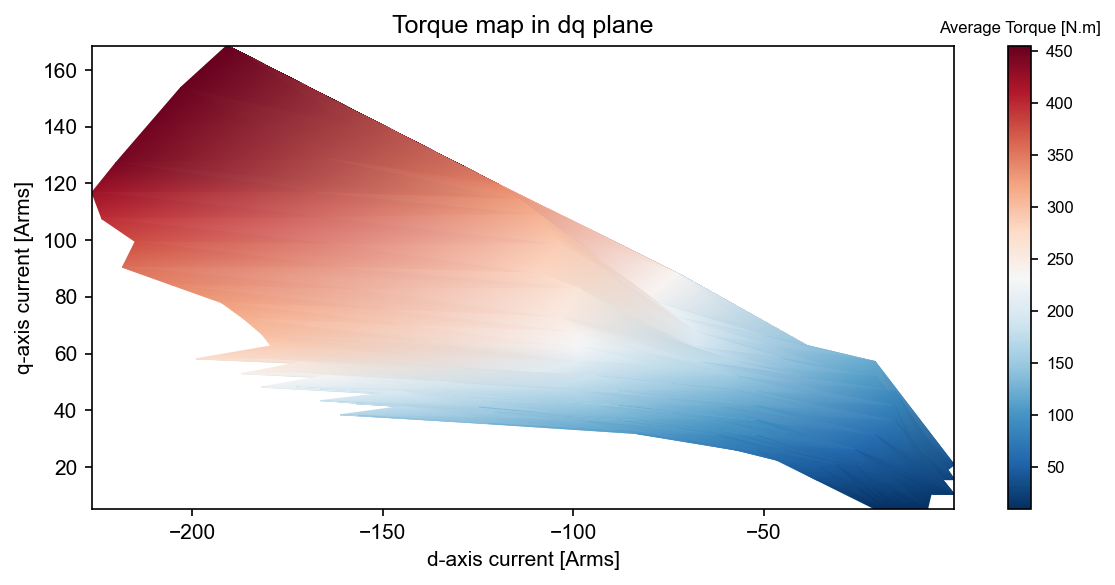

In [20]:
# Init plot map
dict_map = {
    "Xdata": I_MTPA[:, :, 0],  # Id
    "Ydata": I_MTPA[:, :, 1],  # Iq
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolormesh",
    "is_contour": True,
}

# Plot torque maps
plot_3D(
    Zdata=OP_matrix_MTPA[:, :, 3],
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
    **dict_map,
)

## Loss models comparison

It is possible to compare several loss models in PYLEECAN. To do this, a new simulation will be defined and run as before.

In [22]:
simu = Simu1(name="test_loss_models_comparison", machine=machine)


Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=False,
)

# A loss model is created. is_show_fig is set to True to see the curve-fitting figure, otherwise to False
simu.loss = LossFEMM(
    is_get_meshsolution=True,
    Tsta=100,
    model_dict={"stator core Bertotti": LossModelBertotti(group = "stator core"),
                "stator core Steinmetz": LossModelSteinmetz(group = "stator core")}
)

out = simu.run()


[11:15:30] Starting running simulation test_loss_models_comparison (machine=Toyota_Prius)
[11:15:30] Starting Magnetic module
[11:15:32] Solving time steps: 0%
[11:15:32] Solving time steps: 0%
[11:15:32] Solving time steps: 0%
[11:15:33] Solving time steps: 0%
[11:15:40] Solving time steps: 25%
[11:15:40] Solving time steps: 25%
[11:15:41] Solving time steps: 25%
[11:15:46] Solving time steps: 25%
[11:15:49] Solving time steps: 50%
[11:15:49] Solving time steps: 50%
[11:15:52] Solving time steps: 50%
[11:15:53] Solving time steps: 50%
[11:15:56] Solving time steps: 75%
[11:15:57] Solving time steps: 75%
[11:15:58] Solving time steps: 75%
[11:15:58] Solving time steps: 75%
[11:16:00] Solving time step: 100%
[11:16:00] Solving time step: 100%
[11:16:01] Solving time step: 100%
[11:16:01] Solving time step: 100%
[11:16:01] Running LossFEMM module
[11:16:02] End of simulation test_loss_models_comparison


Then, a new output object is created as the difference between the two models defined previously. This object can then be used as any OutLossModel object to visualize the difference.

In [23]:
from pyleecan.Classes.OutLossModel import OutLossModel

out.loss.loss_list.append(OutLossModel(name='difference',
                                    **(out.loss.loss_list[0]-out.loss.loss_list[1])))

group_names = [
    "stator core",
    "rotor core",
    "rotor magnets"
]
loss = out.loss.loss_list[-1]
loss.get_mesh_solution().plot_contour(
    "freqs=sum",
    label=f"{loss.name} Loss",
    group_names = group_names
)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.